In [ ]:
#https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
cmap = plt.get_cmap('jet_r')
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit
import folium
import branca
%matplotlib inline

In [6]:
from data_covid_19_clean import df_countries, df_table, continent_dict
#df_table = pd.read_csv('../input/covid_19_master.csv', parse_dates=['Date'])
df_latest = df_table[df_table['Date'] == max(df_table['Date'])].reset_index()
df_latest_grouped = df_latest.groupby('Country/Region')[
    'Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
has_states = np.unique(df_table[df_table['Province/State']!='NA']['Country/Region'])
has_states

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Ship',
       'United Kingdom', 'United States'], dtype=object)

In [7]:
#df_table[df_table['Country/Region'] == 'Turkey']

In [8]:
pd.set_option('display.max_rows', 20)
df_latest_grouped.sort_values(by='Confirmed', ascending=False)

,Country/Region,Confirmed,Deaths,Recovered
27,China,80945,3180,64196
60,Italy,17660,1266,1439
56,Iran,11364,514,2959
107,South Korea,7979,66,510
109,Spain,5232,133,193
...,...,...,...,...
63,Jordan,1,0,1
15,Bhutan,1,0,0
65,Kenya,1,0,0
31,Cote d'Ivoire,1,0,0


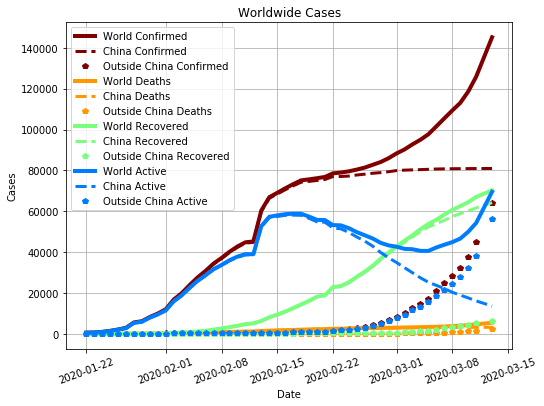

In [11]:
# Worldwide cases
plt.figure(figsize=(8, 6))
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
country = 'China'
#continent = 'Asia'
for ic, col in enumerate(cols):
    plt.plot(df_table.groupby('Date').sum()[col], '-', 
             c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=4, label='World '+col)
    plt.plot(df_table[df_table['Country/Region']==country].groupby('Date').sum()[
        col], '--', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=country+' '+col)
    #plt.plot(df_table[df_table['Continent']==continent].groupby('Date').sum()[
    #    col], ':', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label=continent+' '+col)
    plt.plot(df_table[df_table['Country/Region']!=country].groupby('Date').sum()[
        col], 'p', c=cmap(np.arange(0, 1, 1./len(cols)))[ic], linewidth=3, label='Outside '+country+' '+col)

plt.title('Worldwide Cases')
plt.xlabel('Date')
plt.xticks(rotation=20)
plt.ylabel('Cases')
plt.grid()
plt.legend()
plt.savefig('../figs/world_cases.png')

In [ ]:
# Cases per country
plt.figure(figsize=(16, 6))
Nc = [[1,10],[2,20]]
for ifig in range(2):
    plt.subplot(1, 2, ifig+1)
    countries = df_latest_grouped.sort_values(by='Confirmed', ascending=False)['Country/Region'].values[Nc[ifig][0]:Nc[ifig][1]]
    for ic, country in enumerate(countries):
        df_c = df_table[df_table['Country/Region']==country]
        if (country == 'Iran') or (country == 'South Korea'): continue
        plt.plot(df_c.groupby('Date').sum()['Confirmed'], '-', c=cmap(np.arange(0, 1, 1./Nc[ifig][1]))[ic], 
                 label=country, linewidth=2)
    plt.title('Cases per Country')
    plt.xlabel('Date')
    plt.xticks(rotation=20)
    plt.ylabel('Worldwide Cases')
    plt.grid()
    plt.legend()

In [ ]:
# Recent Growth Rate
d1 = '2020-03-10'
d2 = '2020-03-11'
countries = df_latest_grouped.sort_values(
    by='Confirmed', ascending=False)['Country/Region'].values
daily_growth_confirmed = {}
df_growth = pd.DataFrame(columns=['Country', 'Growth', 'Confirmed'])
for country in countries:
    df_c = df_table[df_table['Country/Region']==country]
    conf1 = df_c[df_c['Date']==d1]['Active'].sum()
    conf2 = df_c[df_c['Date']==d2]['Active'].sum()
    dg = 100*(conf2-conf1)/conf1
    if (conf1>30):
        daily_growth_confirmed[country] = dg
        df_growth = df_growth.append(pd.DataFrame({'Country':[country], 'Growth':[dg], 'Confirmed':[conf2]}))
df_growth = df_growth.sort_values(by='Growth', ascending=False)
fig, ax = plt.subplots(figsize=(8, 8))
y_pos = np.arange(len(df_growth['Country'].values))
ax.barh(y_pos, df_growth['Growth'].values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_growth['Country'].values)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Daily Change of Active Patients ' + d1 + ' and ' + d2)
ax.set_xlabel('Percentage Change [%]')
ax.xaxis.grid() # vertical lines
plt.savefig('../figs/daily_growth.png')

In [ ]:
# Very simple but not realistic forecasting
delt = 0.01
t = np.arange(1, 5, delt)
plt.figure(figsize=(8, 6))
Nc = 10
for irow, row in enumerate(df_growth.iterrows()):
    if (irow == 1) or (irow > Nc): continue
    y = row[1]['Confirmed']*np.power(1.+row[1]['Growth']/100., t)
    plt.plot(t, y, '-', linewidth=3, c=cmap(np.arange(0, 1, 1./(Nc+1)))[irow],
             label=row[1]['Country'])
plt.grid()
plt.title('Forecasting with Exponential Growth (worst case)')
plt.xlabel('Day')
plt.ylabel('Cases')
plt.legend()

In [ ]:
# Chinese regions outside Hubei vs other countries
country = 'China'
df_c = df_table[df_table['Country/Region']==country]
provinces = np.unique(df_c[df_c['Province/State']!='Hubei']['Province/State'])
#fig, ax = plt.subplots(1, 2, sharey=False, figsize=(16, 8))
plt.figure(figsize=(16, 8))
for ip, province in enumerate(provinces):
    df_p = df_c[df_c['Province/State']==province]
    if ip == 0:
        plt.subplot(1, 2, 1)
        plt.plot(df_p['Date'], df_p['Confirmed'], '-k', linewidth=2, label='All states except Hubei')
        plt.subplot(1, 2, 2)
        plt.plot(df_p['Date'], df_p['Confirmed'], '-k', linewidth=2, label='All states except Hubei')
    else:
        plt.subplot(1, 2, 1)
        plt.plot(df_p['Date'], df_p['Confirmed'], '-k', linewidth=2)
        plt.subplot(1, 2, 2)
        plt.plot(df_p['Date'], df_p['Confirmed'], '-k', linewidth=2)
df_p = df_c[df_c['Province/State']=='Hubei']
countries = ['Italy', 'Iran', 'South Korea', 'France', 'Germany', 'United States']
cmap = plt.get_cmap('jet')(np.arange(0, 1, 1./(len(countries)+1)))
for ic, country in enumerate(countries):
    df_c = df_table[df_table['Country/Region']==country].groupby('Date').sum()
    plt.subplot(1, 2, 1)
    plt.plot(df_c.index, df_c['Confirmed'], '-', linewidth=4, label=country, c=cmap[ic])
    plt.subplot(1, 2, 2)
    plt.plot(df_c.index, df_c['Confirmed'], '-', linewidth=4, label=country, c=cmap[ic])
plt.subplot(1, 2, 1)
plt.plot(df_p['Date'], df_p['Confirmed'], c=cmap[-1], linewidth=4, label='Hubei')
plt.title('Cases In All Chinese Provinces vs Other Countries')
plt.xlabel('Date'); plt.xticks(rotation=20); plt.ylabel('Cases');plt.grid(); plt.legend()
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Cases In China Outside Hubei vs Other Countries')
plt.xlabel('Date'); plt.xticks(rotation=20); plt.ylabel('Cases');plt.grid(); plt.legend()
plt.savefig('../figs/hubei_vs_other.png')

In [ ]:
# straight line
def line(x, a, b):
    return a*x + b

In [ ]:
# Estimate true death rate
country = 'China'
province = 'Hubei'
df_c = df_table[df_table['Country/Region']==country]
df_p = df_c[df_c['Province/State']==province]
df_p['Death_Closed'] = 100*df_p['Deaths']/(df_p['Closed'])
df_p['Death_Total'] = 100*df_p['Deaths']/(df_p['Confirmed'])

t = np.array(range(df_p.shape[0]))[-10:]+1
popt_closed, pcov = curve_fit(line, t, df_p['Death_Closed'].values[-10:], sigma=1./np.power(t, 2))
popt_total, pcov = curve_fit(line, t, df_p['Death_Total'].values[-10:], sigma=1./np.power(t, 2))
death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(df_p['Date'], df_p['Death_Closed'], '-b', linewidth=3, label='Death/Closed')
plt.plot(df_p['Date'], df_p['Death_Total'],  '-r', linewidth=3, label='Death/Total')
#plt.plot(df_p['Date'].values[-10:], line(t, popt_closed[0], popt_closed[1]), '--b', linewidth=3)
#plt.plot(df_p['Date'].values[-10:], line(t, popt_total[0], popt_total[1]), '--r', linewidth=3)
plt.title('Death Rates In {:s}: %{:3.2f}'.format(province, death_true))
plt.xlabel('Date'); plt.xticks(rotation=20); plt.ylabel('Percentage'); plt.ylim([0, 35]); plt.grid(); plt.legend()

df_p = df_c[df_c['Province/State']!=province]
df_p = df_p.groupby('Date').sum()
df_p['Death_Closed'] = 100*df_p['Deaths']/(df_p['Closed'])
df_p['Death_Total'] = 100*df_p['Deaths']/(df_p['Confirmed'])
popt_closed, pcov = curve_fit(line, t, df_p['Death_Closed'].values[-10:], sigma=1./np.power(t, 2))
popt_total, pcov = curve_fit(line, t, df_p['Death_Total'].values[-10:], sigma=1./np.power(t, 2))
death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
plt.subplot(1, 2, 2)
plt.plot(df_p.index, df_p['Death_Closed'], '-b', linewidth=3, label='Death/Closed')
plt.plot(df_p.index, df_p['Death_Total'],  '-r', linewidth=3, label='Death/Total')
#plt.title('Death Rates in Chinese Provinces Outside {:s}: %{0:.2f}'.format(province, death_true))
plt.title('Death Rates In {:s} Outside {:s}: %{:3.2f}'.format(country, province, death_true))
plt.xlabel('Date'); plt.xticks(rotation=20); plt.ylabel('Percentage'); plt.ylim([0, 35]); plt.grid(); plt.legend()
plt.savefig('../figs/' + country + '_death_rate.png')

In [ ]:
Nlast = 15
plt.figure(figsize=(8, 6))
country = 'South Korea'
df_c = df_table[df_table['Country/Region']==country].groupby('Date').sum()
t = np.array(range(df_c.shape[0]))[-Nlast:]+1
df_c['Death_Closed'] = 100*df_c['Deaths']/(df_c['Confirmed']-df_c['Active'])
df_c['Death_Total'] = 100*df_c['Deaths']/(df_c['Confirmed'])
indx_closed = np.where(np.isnan(df_c['Death_Closed'].values[-Nlast:])*(-1)+1)
indx_total = np.where(np.isnan(df_c['Death_Total'].values[-Nlast:])*(-1)+1)
popt_closed, pcov = curve_fit(line, t[indx_closed], df_c['Death_Closed'].values[-Nlast:][indx_closed], sigma=1./df_c['Closed'].values[-Nlast:][indx_closed])
popt_total, pcov = curve_fit(line, t[indx_total], df_c['Death_Total'].values[-Nlast:][indx_total], sigma=1./df_c['Confirmed'].values[-Nlast:][indx_total])
death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
plt.plot(df_c.index, df_c['Death_Closed'], '-b', linewidth=3, label='Death/Closed')
plt.plot(df_c.index, df_c['Death_Total'],  '-r', linewidth=3, label='Death/Total')
plt.title('Death Rates in {:s}: %{:3.2f}'.format(country, death_true))
plt.xlabel('Date')
plt.xticks(rotation=20)
plt.ylabel('Percentage')
plt.legend()
plt.grid()
plt.savefig('../figs/' + country + '_death_rate.png')

In [ ]:
Nlast = 15
countries = ['China', 'Italy', 'Iran', 'South Korea','Australia', 'Ship', 'Japan', 'Taiwan']
nx = np.ceil(np.sqrt(len(countries)))
ny = nx
plt.figure(figsize=(8*nx, 8*ny))
for ic, country in enumerate(countries):
    plt.subplot(nx, ny, ic+1)
    df_c = df_table[df_table['Country/Region']==country].groupby('Date').sum()
    t = np.array(range(df_c.shape[0]))[-Nlast:]+1
    df_c['Death_Closed'] = 100*df_c['Deaths']/(df_c['Confirmed']-df_c['Active'])
    df_c['Death_Total'] = 100*df_c['Deaths']/(df_c['Confirmed'])
    indx_closed = np.where(np.isnan(df_c['Death_Closed'].values[-Nlast:])*(-1)+1)
    indx_total = np.where(np.isnan(df_c['Death_Total'].values[-Nlast:])*(-1)+1)
    popt_closed, pcov = curve_fit(line, t[indx_closed], df_c['Death_Closed'].values[-Nlast:][indx_closed], sigma=1./df_c['Closed'].values[-Nlast:][indx_closed])
    popt_total, pcov = curve_fit(line, t[indx_total], df_c['Death_Total'].values[-Nlast:][indx_total], sigma=1./df_c['Confirmed'].values[-Nlast:][indx_total])
    death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
    plt.plot(df_c.index, df_c['Death_Closed'], '-b', linewidth=3, label='Death/Closed')
    plt.plot(df_c.index, df_c['Death_Total'],  '-r', linewidth=3, label='Death/Total')
    plt.plot(df_c.index[-Nlast:], line(t, popt_closed[0], popt_closed[1]), '--b', linewidth=5)
    plt.plot(df_c.index[-Nlast:], line(t, popt_total[0], popt_total[1]), '--r', linewidth=5)
    plt.title('Death Rates in {:s}: %{:3.2f}'.format(country, death_true))
    plt.xlabel('Date')
    plt.xticks(rotation=20)
    plt.ylabel('Percentage')
    plt.legend()
    plt.grid()
plt.savefig('../figs/countries_death_rate.png')

In [ ]:
Nlast = 20
countries = df_latest_grouped.sort_values(by='Confirmed', ascending=False)['Country/Region'].values[:50]
df_death = pd.DataFrame(columns=['Country', 'Death_Rate'])
for ic, country in enumerate(countries):
    df_c = df_table[df_table['Country/Region']==country].groupby('Date').sum()
    t = np.array(range(df_c.shape[0]))[-Nlast:]+1
    df_c['Death_Closed'] = 100*df_c['Deaths']/(df_c['Closed'])
    df_c['Death_Total'] = 100*df_c['Deaths']/(df_c['Confirmed'])
    indx_closed = np.where(np.isnan(df_c['Death_Closed'].values[-Nlast:])*(-1)+1)
    indx_total = np.where(np.isnan(df_c['Death_Total'].values[-Nlast:])*(-1)+1)
    if (len(indx_closed[0]) < 10) or (df_c['Closed'].max() < 10):
        continue;
    popt_closed, pcov = curve_fit(line, t[indx_closed], df_c['Death_Closed'].values[-Nlast:][indx_closed], sigma=1./df_c['Closed'].values[-Nlast:][indx_closed])
    popt_total, pcov = curve_fit(line, t[indx_total], df_c['Death_Total'].values[-Nlast:][indx_total], sigma=1./df_c['Confirmed'].values[-Nlast:][indx_total])
    death_true = -(popt_closed[1]-popt_total[1])/(popt_closed[0]-popt_total[0])*popt_closed[0]+popt_closed[1]
    df_death = df_death.append(pd.DataFrame({'Country':[country], 'Death_Rate':[death_true]}))
df_death

In [ ]:
#df_full = df.groupby(['Country/Region', 'Province/State']).agg({
#    'Confirmed':'max', 'Deaths':'max', 'Recovered':'max','Lat':'mean', 'Long':'mean'})

In [ ]:
r = 100+(np.log10(df_latest['Confirmed']))*2e4
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, np.max(r.values))

In [ ]:
m = folium.Map(location=[0, 0], tiles='Stamen Toner',
               min_zoom=1, max_zoom=10, zoom_start=1)
for i in range(df_latest.shape[0]):
    folium.Circle(location=[df_latest.iloc[i]['Lat'], df_latest.iloc[i]['Long']],
                  radius=r[i], color='red', 
                  tooltip = '<li><bold>Country: ' + df_latest.iloc[i]['Country/Region'] + '</bold</li>' + 
                  '<li><bold>Province: ' + df_latest.iloc[i]['Province/State'] + '</bold</li>' +  
                  '<li><bold>Lat: ' + str(df_latest.iloc[i]['Lat']) + '</bold</li>' +  
                  '<li><bold>Long: ' + str(df_latest.iloc[i]['Long']) + '</bold</li>' +  
                  '<li><bold><font color="red">Confirmed: ' + str(df_latest.iloc[i]['Confirmed']) + '</font></bold</li>' + 
                  '<li><bold>Deaths: ' + str(df_latest.iloc[i]['Deaths']) + '</bold</li>' + 
                  '<li><bold><font color="green">Recovered: ' + str(df_latest.iloc[i]['Recovered']) + '</font></bold</li>',
                  fill_color='red', opacity=1
                 ).add_to(m)
m